In [143]:
%matplotlib inline

from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import os.path as path
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer as count_vectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB as multinomial_nb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import load_digits
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import string
import time
import operator
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Activation, Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from matplotlib import colors as mcolors

In [144]:
def convert(x):
    # load json object
    ob = json.loads(x)
    
    # parse through objects in json and join as a csv or dict
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

In [145]:
def text_process(text, weak_sentiment_word_list):
    # instantiate word_list array
    word_list = []
    
    # parse characters of text and remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # parse word by word in text convert to lowercase and remove stopwords and weak sentiment words
    for word in nopunc.split():
        word = word.lower()
        if word not in stopwords.words('english'):
            if word not in weak_sentiment_word_list:
                word_list.append(word.lower())
        
    return word_list

In [146]:
def normalize_dataset(yelp):
    # instantiate yelp_normalized array
    yelp_normalized = []
    
    # create datasets separated by type of star
    yelp_1 = yelp[(yelp['stars'] == 1)]
    yelp_2 = yelp[(yelp['stars'] == 2)]
    yelp_3 = yelp[(yelp['stars'] == 3)]
    yelp_4 = yelp[(yelp['stars'] == 4)]
    yelp_5 = yelp[(yelp['stars'] == 5)]
    
    # determine the lowest count in datasets
    limiting_factor = min([len(yelp_1), len(yelp_2), len(yelp_3), len(yelp_4), len(yelp_5)])
        
    # concatenate all datasets into one dataset
    yelp_normalized.append(yelp_1.sample(limiting_factor))
    yelp_normalized.append(yelp_2.sample(limiting_factor))
    yelp_normalized.append(yelp_3.sample(limiting_factor))
    yelp_normalized.append(yelp_4.sample(limiting_factor))
    yelp_normalized.append(yelp_5.sample(limiting_factor))
    
    return pd.concat(yelp_normalized)

In [147]:
def generate_string(yelp, rating):
    # create dataset unique to a star rating and instantiate a string array
    yelp = yelp[(yelp['stars'] == rating)]
    string = []
    
    # parse tokenized text in each review
    for text in yelp['tokenized']:
        # parse tokens in tokenized text and append them to string array
        for token in text:
            string.append(token)
    return pd.Series(string).str.cat(sep=' ')

In [148]:
def generate_list(string_count, length):
    # instantiate word_list and set count to 0
    word_list = []
    count = 0
    
    # parse words in string_count 
    for word in string_count:
        # append the word while count is less than length
        if count < length:
            count += 1
            word_list.append(word[0])
        else:
            break
    
    return word_list

In [149]:
def generate_weak_sentiment_list(yelp):
    # instantiate weak_sentiment_word_list array
    weak_sentiment_word_list = []

    # generate a positive and negative string based on 1 and 5 stars
    yelp_negative_string = generate_string(yelp, 1)
    yelp_positive_string = generate_string(yelp, 5)

    # sort items in positive and necative arrays from greatest to least
    positive_string_count = sorted(word_count(yelp_positive_string).items(), 
                                   key=operator.itemgetter(1), 
                                   reverse = True)
    
    negative_string_count = sorted(word_count(yelp_negative_string).items(), 
                                   key=operator.itemgetter(1), 
                                   reverse = True)
    
    # arbitrarily set a length based on the length of both arrays
    length = int((len(positive_string_count) + len(negative_string_count)) * 0.001 / 2)
    
    # generate positive and negative word lists
    positive_word_list = generate_list(positive_string_count, length)
    negative_word_list = generate_list(negative_string_count, length)
    
    # parse words in the lists and if they match add them to the weak sentiment array
    for word in positive_word_list:
        if word in negative_word_list:
            weak_sentiment_word_list.append(word)
    return weak_sentiment_word_list

In [150]:
def convert_review_large_csv(override):
    # load json into memory if it does not exist or there is an override to overwrite the file
    if not path.exists('./dataset/review_large.csv') or override:
        for json_filename in glob('*.json'):
            # create csv of the same name as json
            csv_filename = '%s.csv' % json_filename[:-5]
            print('Converting %s to %s' % (json_filename, csv_filename))
            
            # parse lines of json in memory and add them to a dataframe and convert dataframe into a csv
            df = pd.DataFrame([convert(line) for line in open(json_filename)])
            df.to_csv(csv_filename, encoding='utf-8', index=False)
    else:
        print('review.csv already exists and no override detected')

In [151]:
def clean_dataset(yelp):
    # instantiate a weak_sentiment_list array
    weak_sentiment_list = []
    
    # retype text to string 
    yelp['text'] = yelp['text'].astype(str)
    
    # create length and tokenized columns 
    yelp['length'] = yelp['text'].apply(len)
    yelp['tokenized'] = yelp.apply(lambda row: text_process(row['text'], weak_sentiment_list), axis=1)
    
    # generate a weak sentiment word list and apply it to the tokenized column
    weak_sentiment_list = generate_weak_sentiment_list(yelp)
    yelp['tokenized'] = yelp.apply(lambda row: text_process(row['text'], weak_sentiment_list), axis=1)
    
    return yelp, weak_sentiment_list

In [152]:
def create_class(yelp, boundary):
    # generate class of yelp based on stars included
    if not boundary:
        yelp_class = yelp
    else:
        yelp_class = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)]
    
    return yelp_class

In [153]:
def generate_X_y(yelp_class):
    # instantiate X_list array
    X_list = []
    
    # create X and y and assign appropriate columns
    X = yelp_class['tokenized']
    y = yelp_class['stars']
    
    # parse items in column and append them to X_list array
    for item in X:
        X = ' '.join(item)
        X_list.append(X)
    
    return X_list, y

In [154]:
def bow_transformer(X):
    # vectorize words in X with an ngram of 1 and setting a feature ceiling at 450,000 
    # the feature ceiling was set to extend the boundary case without conflicts
    bow_transformer = count_vectorizer(ngram_range=(1, 2), max_features=450000).fit(X)
    
    # transform vectorize words
    X = bow_transformer.transform(X)
    
    return X

In [155]:
def word_count(str):
    # instantiate a counts dictionary and split the words in str
    counts = dict()
    words = str.split()

    # parse words in text and if the word is in the dictionary increment it's value
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [156]:
def classifier_train(classifier, X_train, y_train, X_test, y_test):
    # set time and fit classifier
    t0 = time.time()
    classifier.fit(X_train, y_train)
    
    # set time and use the classifier to predict the test values  
    t1 = time.time()
    prediction = classifier.predict(X_test)
    
    # set completion time
    t2 = time.time()
    
    # determine training and prediction times
    time_train = t1-t0
    time_predict = t2-t1
    
    # evaluate accuracy of the classifier based on the test case
    score = classifier.score(X_test, y_test)
    print('Score: {0}'.format(score))
    print('\n')
    
    # evaluate the confusion matrix based on the predictions generated by the classifier
    confusion_matrix = metrics.confusion_matrix(y_test, prediction)
    print('Confusion Matrix: \n {0}'.format(confusion_matrix))
    print('\n')
    
    print('Training time: {0:.3f}s; Prediction time: {1:.3f}s'.format(time_train, time_predict))
    print(classification_report(y_test, prediction))
    
    return classifier, prediction, time_train, time_predict, score, confusion_matrix

In [157]:
def classifier_train_nn(classifier, X_train, y_train, X_test, y_test, batch_size, epochs):
    # set time and fit classifier
    t0 = time.time()
    classifier.fit(X_train,
                   y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split=0.1)
    
    # set time and use the classifier to predict the test values  
    t1 = time.time()
    prediction = classifier.predict_classes(X_test,
                                            verbose=1)
    
    # set completion time
    t2 = time.time()
    
    # determine training and prediction times
    time_train = t1-t0
    time_predict = t2-t1
    
    # evaluate accuracy of the classifier based on the test case
    score, accuracy = classifier.evaluate(X_test,
                                          y_test,
                                          batch_size=batch_size, 
                                          verbose=1)
    print('\n')
    print('Score: {0}'.format(score))
    print('Accuracy: {0}'.format(accuracy))
    print('\n')
    
    # evaluate the confusion matrix based on the predictions generated by the classifier
    confusion_matrix = metrics.confusion_matrix(y_test, prediction)
    print('Confusion Matrix: \n {0}'.format(confusion_matrix))
    print('\n')
    
    print('Training time: {0:.3f}s; Prediction time: {1:.3f}s'.format(time_train, time_predict))
    print(classification_report(y_test, prediction))
    
    return classifier, prediction, time_train, time_predict, score, accuracy, confusion_matrix

In [158]:
def classifier_evaluate(classifier, X_test, y_test):
    # set time and use the classifier to predict the test values  
    t0 = time.time()
    
    # generate the predictions and the probabilities attached to the predictions
    prediction = classifier.predict(X_test)
    prediction_probability = classifier.predict_proba(X_test)
    
    # parse the predictions and probabilities and based on find the difference in the probabilities
    for i in range(prediction.size):
        prediction_delta = prediction_probability[i][0] - prediction_probability[i][1]

        # based on the difference value set the star prediction
        if prediction_delta > 0.75:
            prediction[i] = 1
        elif prediction_delta > 0.25:
            prediction[i] = 2    
        elif prediction_delta > -0.25:
            prediction[i] = 3
        elif prediction_delta > -0.75:
            prediction[i] = 4
        else:
            prediction[i] = 5
    
    # set completion time
    t1 = time.time()
    
    # determine and prediction time
    time_predict = t1-t0
    
    # evaluate accuracy of the classifier based on the test case
    score = (prediction.size - np.count_nonzero(prediction - y_test.values)) / prediction.size
    print('Score: {0}'.format(score))
    print('\n')
    
    # evaluate the confusion matrix based on the predictions generated by the classifier
    confusion_matrix = metrics.confusion_matrix(y_test, prediction)
    print('Confusion Matrix: \n {0}'.format(confusion_matrix))
    print('\n')
    
    print('Prediction time: {0:.3f}s'.format(time_predict))
    print(classification_report(y_test, prediction))
    
    return classifier, prediction, time_predict, score, confusion_matrix

In [159]:
def classifier_evaluate_nn(classifier, X_test, y_test):
    # set time and use the classifier to predict the test values  
    t0 = time.time()
    
    # generate the predictions and the probabilities attached to the predictions
    prediction = classifier.predict_classes(X_test, verbose=1)
    prediction_probability = classifier.predict(X_test)
    
    # parse the predictions and probabilities and based on find the difference in the probabilities
    for i in range(prediction.size):
        prediction_delta = prediction_probability[i][0] - prediction_probability[i][1]

        # based on the difference value set the star prediction
        if prediction_delta > 0.75:
            prediction[i] = 1
        elif prediction_delta > 0.25:
            prediction[i] = 2    
        elif prediction_delta > -0.25:
            prediction[i] = 3
        elif prediction_delta > -0.75:
            prediction[i] = 4
        else:
            prediction[i] = 5
    
    # set completion time
    t1 = time.time()
    
    # determine and prediction time
    time_predict = t1-t0
    
    # evaluate accuracy of the classifier based on the test case
    score = (prediction_ln_boundary_extended.size - np.count_nonzero(prediction_ln_boundary_extended - y_complete_test.values)) / prediction_ln_boundary_extended.size
    print('Score: {0}'.format(score))
    print('\n')
    
    # evaluate the confusion matrix based on the predictions generated by the classifier
    confusion_matrix = metrics.confusion_matrix(y_test, prediction)
    print('Confusion Matrix: \n {0}'.format(confusion_matrix))
    print('\n')
    
    print('Prediction time: {0:.3f}s'.format(time_predict))
    print(classification_report(y_test, prediction))
    
    return classifier, prediction, time_predict, score, confusion_matrix

In [160]:
def classifier_result(confusion_matrix, score, classifier_string):
    # normalize confusion matrix
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    # generate confusion matrix plot
    plt.figure(figsize=(6,6))
    sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    all_sample_title = '{0} \n Accuracy Score: {1:.4f}'.format(classifier_string, score)
    plt.title(all_sample_title, size = 15)
    
    # save plot
    classifier_string = classifier_string.lower()
    classifier_string = classifier_string.replace(" ", "_")
    plt.savefig('./report_4_images/{0}_confusion_matrix.png'.format(classifier_string))
    
    plt.show()

In [161]:
def classifier_roc(prediction, y_test, classifier_string):
    # evaluate the roc and values based on the prediction and test labels
    fpr, tpr, thresholds = roc_curve(y_test, prediction, pos_label=1)
    roc_auc = auc(tpr, fpr)
    
    # generate roc plot
    plt.title('{0} \n Receiver Operating Characteristic'.format(classifier_string))
    plt.plot(tpr, fpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # save plot
    classifier_string = classifier_string.lower()
    classifier_string = classifier_string.replace(" ", "_")
    plt.savefig('./report_4_images/{0}_roc.png'.format(classifier_string))
    
    plt.show()
    
    print("AUC of the predictions: {0}".format(roc_auc))

    return fpr, tpr, thresholds, roc_auc

In [162]:
def classifiers_plots(fprs, tprs, roc_aucs, time_trains, time_predicts, classifier_strings, title):
    # determine the number of classes and set the line width
    n_classes = len(classifier_strings)
    lw = 2

    # plot all roc curves
    plt.figure()
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    
    # assign colors
    for i, color in zip(range(n_classes), colors):
        plt.plot(tprs[i], fprs[i], color=color, lw=lw,
                 label='{0} (auc = {1:0.2f})'
                 ''.format(classifier_strings[i], roc_aucs[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0} ROCs'.format(title))
    plt.legend(loc="lower right")
    
    # save plot
    plot_title = title.lower()
    plt.savefig('./report_4_images/{0}_roc_curves.png'.format(title))
    
    plt.show()
    
    # plot train and predict times
    # determine the number of groups
    n_groups = len(classifier_strings)
    fig, ax = plt.subplots()

    # set index, bar widths, and opacity
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.4

    # create bars for the bar plot
    time_trains_bars = plt.bar(index, 
                     time_trains,
                     bar_width,
                     alpha=opacity,
                     color='b',
                     label='Training Time',
                     log=True)

    time_predicts_bars = plt.bar(index + bar_width, 
                     time_predicts, 
                     bar_width,
                     alpha=opacity,
                     color='r',
                     label='Pretiction Time',
                     log=True)

    plt.ylabel('Time')
    plt.title('{0} Training and Prediction Times'.format(title))
    
    strings = []
    
    # parse and format strings in classifiers
    for string in classifier_strings:
        string = string.replace(' {0}'.format(title), '')
        strings.append(string)
    
    plt.xticks(index + bar_width / 2, 
               strings,
               rotation='vertical')
    
    # set legend location
    plt.legend(loc="lower right")

    # create a helper function to label bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2.,
                     1.05*height,
                     '{0:.2f}'.format(height),
                     ha='center', 
                     va='bottom')
    
    autolabel(time_trains_bars)
    autolabel(time_predicts_bars)

    # save plot
    plt.savefig('./report_4_images/{0}_training_prediction_times.png'.format(title))

    plt.show()

In [132]:
# load review dataset
# './dataset/review_medium.csv' or './dataset/review_small.csv'
yelp = pd.read_csv('./dataset/review_medium.csv')

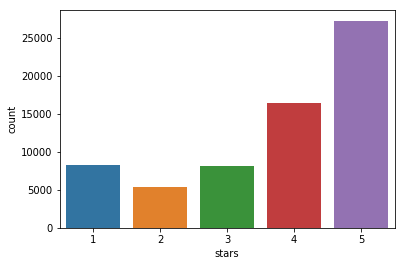

In [133]:
# plot distribution of stars
sns.countplot(x='stars', data=yelp)

In [22]:
# normalize dataset
yelp = normalize_dataset(yelp)

In [23]:
# clean dataset
yelp_clean, weak_sentiment_list = clean_dataset(yelp)
yelp_clean.describe()

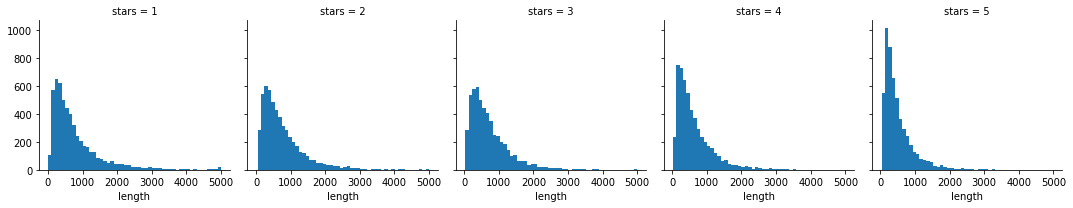

In [27]:
# plot review length with respect to stars
g = sns.FacetGrid(data=yelp, col='stars')
g.map(plt.hist, 'length', bins=50)

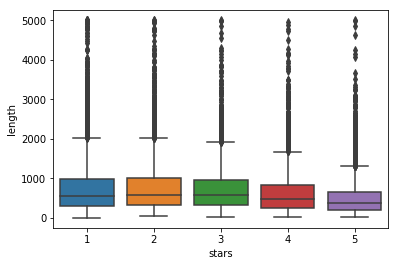

In [123]:
# plot review length with respect to stars in boxplots
sns.boxplot(x='stars', y='length', data=yelp)

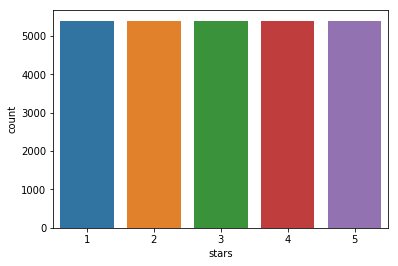

In [125]:
# plot distribution of stars
sns.countplot(x='stars', data=yelp)

In [30]:
stars = yelp.groupby('stars').mean()
stars

,cool,funny,useful,length
stars,,,,
1,0.315107,0.751622,2.487303,781.876552
2,0.409824,0.650046,1.584430,775.263021
3,0.637998,0.611307,1.411677,727.423170
4,0.856719,0.567563,1.392215,631.120667
5,0.610751,0.369787,1.105653,513.769972


In [31]:
stars.corr()

,cool,funny,useful,length
cool,1.000000,-0.544003,-0.709294,-0.610741
funny,-0.544003,1.000000,0.849792,0.953178
useful,-0.709294,0.849792,1.000000,0.720640
length,-0.610741,0.953178,0.720640,1.000000


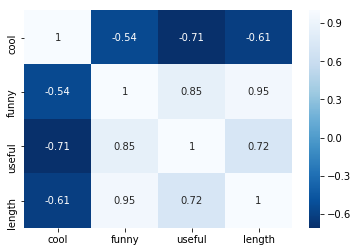

In [126]:
# plot correlations 
sns.heatmap(data=stars.corr(), annot=True, cmap = 'Blues_r')

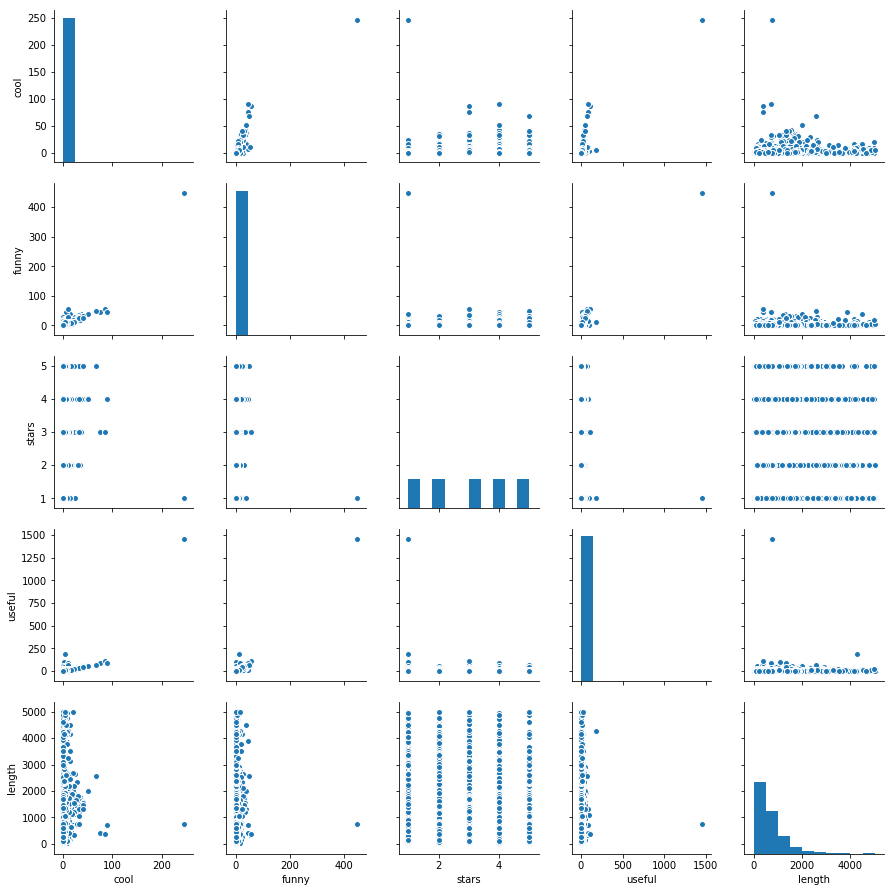

In [34]:
# plot pairwise correlations 
sns.pairplot(yelp)
plt.show()

In [128]:
# show list of weak sentiment words
print(weak_sentiment_list)

['place', 'food', 'good', 'service', 'time', 'one', 'get', 'like', 'back', 'go', 'would']


In [37]:
# generate negative word string
negative_string = generate_string(yelp, 1)

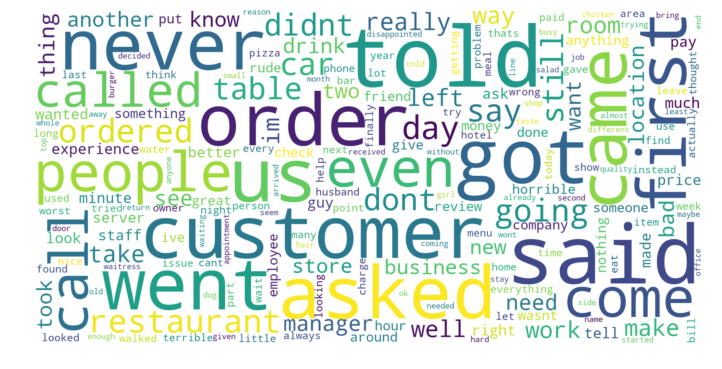

In [38]:
# generate negative word cloud plot
wordcloud = WordCloud(background_color="white", width=1600, height=800,max_font_size=200).generate(negative_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# save plot
plt.savefig('./report_4_images/wordcloud_negative.png')

plt.show()

In [39]:
# generate positive word string
positive_string = generate_string(yelp, 5)

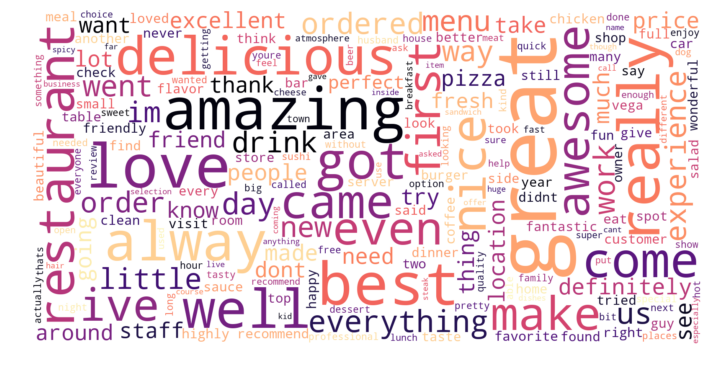

In [40]:
# generate positive word cloud plot
wordcloud = WordCloud(background_color="white", width=1600, height=800,max_font_size=200,colormap='magma').generate(positive_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# save plot
plt.savefig('./report_4_images/wordcloud_positive.png')

plt.show()

In [41]:
# create class spanning all stars
yelp_class_complete = create_class(yelp, boundary = False)

In [42]:
# generate reviews and labels
X_complete, y_complete = generate_X_y(yelp_class_complete)

In [43]:
# perform vectorization on class
X_complete = bow_transformer(X_complete)

In [45]:
# split class into training and testing sets
X_complete_train, X_complete_test, y_complete_train, y_complete_test = train_test_split(X_complete, y_complete, test_size=0.3, random_state=101)

In [46]:
# create class spanning only the 1 and 5 stars
yelp_class_boundary = create_class(yelp, boundary = True)

In [47]:
# generate reviews and labels
X_boundary, y_boundary = generate_X_y(yelp_class_boundary)

In [48]:
# perform vectorization on class
X_boundary = bow_transformer(X_boundary)

In [49]:
# split class into training and testing sets
X_boundary_train, X_boundary_test, y_boundary_train, y_boundary_test = train_test_split(X_boundary, y_boundary, test_size=0.3, random_state=101)

# Complete Conditions

### Multinomial Naive Bayes Classifier

In [50]:
# create and train multinomial naive bayes classifier
classifier_nb_complete = multinomial_nb()
classifier_nb_complete, prediction_nb_complete, time_train_nb_complete, time_predict_nb_complete, score_nb_complete, confusion_matrix_nb_complete = classifier_train(classifier_nb_complete, X_complete_train, y_complete_train, X_complete_test, y_complete_test)

Score: 0.5162486099097986


Confusion Matrix: 
 [[1156  391   78   17    5]
 [ 366  745  463   71    8]
 [ 136  326  832  268   26]
 [  67  103  495  736  161]
 [ 134   83  173  544  709]]


Training time: 0.140s; Prediction time: 0.028s
             precision    recall  f1-score   support

          1       0.62      0.70      0.66      1647
          2       0.45      0.45      0.45      1653
          3       0.41      0.52      0.46      1588
          4       0.45      0.47      0.46      1562
          5       0.78      0.43      0.56      1643

avg / total       0.54      0.52      0.52      8093



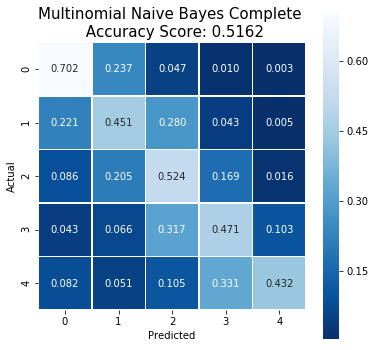

In [51]:
# evaluate and plot the confusion matrix
classifier_string_nb_complete = 'Multinomial Naive Bayes Complete'
classifier_result(confusion_matrix_nb_complete, score_nb_complete, classifier_string_nb_complete)

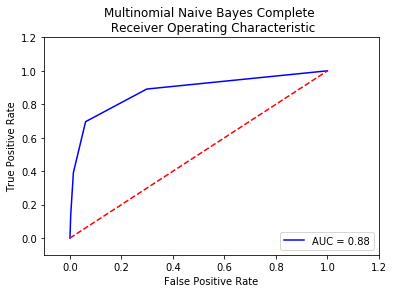

AUC of the predictions: 0.8806760606682276


In [52]:
# evaluate and plot the roc curve
fpr_nb_complete, tpr_nb_complete, thresholds_nb_complete, roc_auc_nb_complete = classifier_roc(prediction_nb_complete, y_complete_test, classifier_string_nb_complete)

### Linear SVM Classifier

In [53]:
# create and train linear svm classifier
classifier_ln_complete = svm.SVC(kernel='linear')
classifier_ln_complete, prediction_ln_complete, time_train_ln_complete, time_predict_ln_complete, score_ln_complete, confusion_matrix_ln_complete = classifier_train(classifier_ln_complete, X_complete_train, y_complete_train, X_complete_test, y_complete_test)

Score: 0.5393549981465464


Confusion Matrix: 
 [[1171  338   67   32   39]
 [ 399  720  355  126   53]
 [  99  348  671  376   94]
 [  33  107  319  720  383]
 [  36   47   94  383 1083]]


Training time: 279.030s; Prediction time: 69.953s
             precision    recall  f1-score   support

          1       0.67      0.71      0.69      1647
          2       0.46      0.44      0.45      1653
          3       0.45      0.42      0.43      1588
          4       0.44      0.46      0.45      1562
          5       0.66      0.66      0.66      1643

avg / total       0.54      0.54      0.54      8093



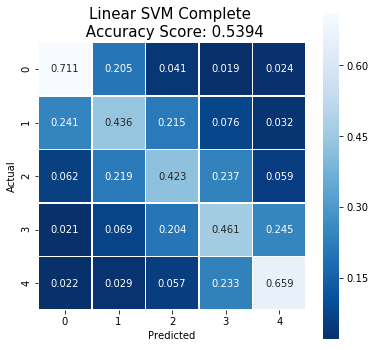

In [54]:
# evaluate and plot the confusion matrix
classifier_string_ln_complete = 'Linear SVM Complete'
classifier_result(confusion_matrix_ln_complete, score_ln_complete, classifier_string_ln_complete)

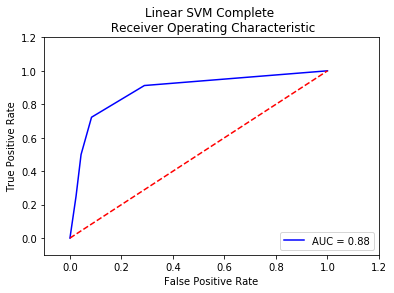

AUC of the predictions: 0.8825299094000487


In [55]:
# evaluate and plot the roc curve
fpr_ln_complete, tpr_ln_complete, thresholds_ln_complete, roc_auc_ln_complete = classifier_roc(prediction_ln_complete, y_complete_test, classifier_string_ln_complete)

### Linear SVC Classifier

In [56]:
# create and train linear svc classifier
classifier_lnlib_complete = svm.LinearSVC()
classifier_lnlib_complete, prediction_lnlib_complete, time_train_lnlib_complete, time_predict_lnlib_complete, score_lnlib_complete, confusion_matrix_lnlib_complete = classifier_train(classifier_lnlib_complete, X_complete_train, y_complete_train, X_complete_test, y_complete_test)

Score: 0.5253923143457309


Confusion Matrix: 
 [[1162  312   83   37   53]
 [ 411  662  369  138   73]
 [ 107  344  613  403  121]
 [  36  112  296  684  434]
 [  41   37   75  359 1131]]


Training time: 19.281s; Prediction time: 0.033s
             precision    recall  f1-score   support

          1       0.66      0.71      0.68      1647
          2       0.45      0.40      0.42      1653
          3       0.43      0.39      0.41      1588
          4       0.42      0.44      0.43      1562
          5       0.62      0.69      0.65      1643

avg / total       0.52      0.53      0.52      8093



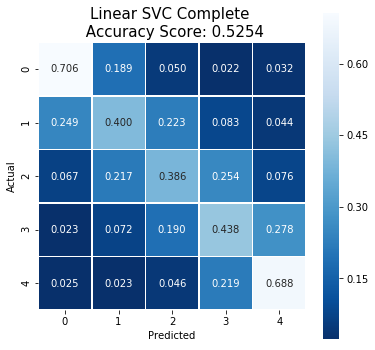

In [57]:
# evaluate and plot the confusion matrix
classifier_string_lnlib_complete = 'Linear SVC Complete'
classifier_result(confusion_matrix_lnlib_complete, score_lnlib_complete, classifier_string_lnlib_complete)

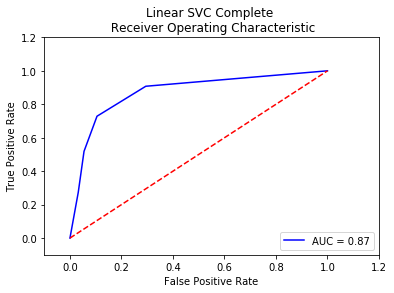

AUC of the predictions: 0.8726467193428531


In [58]:
# evaluate and plot the roc curve
fpr_lnlib_complete, tpr_lnlib_complete, thresholds_lnlib_complete, roc_auc_lnlib_complete = classifier_roc(prediction_lnlib_complete, y_complete_test, classifier_string_lnlib_complete)

### Logistic Regression Classifier

In [59]:
# create and train logistic regression classifier
classifier_lr_complete = LogisticRegression()
classifier_lr_complete, prediction_lr_complete, time_train_lr_complete, time_predict_lr_complete, score_lr_complete, confusion_matrix_lr_complete = classifier_train(classifier_lr_complete, X_complete_train, y_complete_train, X_complete_test, y_complete_test)

Score: 0.5512171011985667


Confusion Matrix: 
 [[1218  291   61   29   48]
 [ 403  695  367  120   68]
 [ 102  329  660  388  109]
 [  32   98  293  724  415]
 [  34   30   73  342 1164]]


Training time: 20.133s; Prediction time: 0.029s
             precision    recall  f1-score   support

          1       0.68      0.74      0.71      1647
          2       0.48      0.42      0.45      1653
          3       0.45      0.42      0.43      1588
          4       0.45      0.46      0.46      1562
          5       0.65      0.71      0.68      1643

avg / total       0.54      0.55      0.55      8093



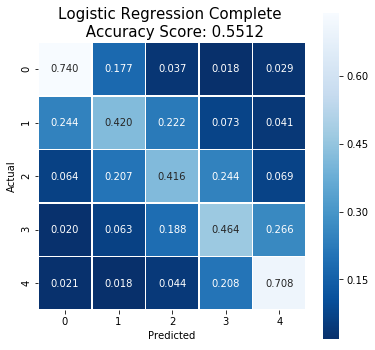

In [60]:
# evaluate and plot the confusion matrix
classifier_string_lr_complete = 'Logistic Regression Complete'
classifier_result(confusion_matrix_lr_complete, score_lr_complete, classifier_string_lr_complete)

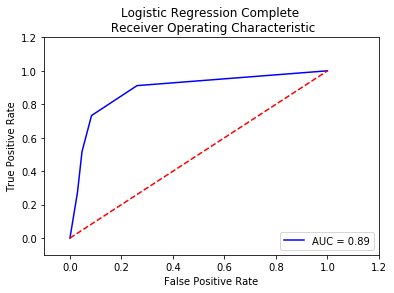

AUC of the predictions: 0.8860689081832707


In [61]:
# evaluate and plot the roc curve
fpr_lr_complete, tpr_lr_complete, thresholds_lr_complete, roc_auc_lr_complete = classifier_roc(prediction_lr_complete, y_complete_test, classifier_string_lr_complete)

### Random Forest Classifier

In [62]:
# create and train random forest classifier with 100 estimators and bootstaping enabled
classifier_rfc_complete = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True, random_state=0)
classifier_rfc_complete, prediction_rfc_complete, time_train_rfc_complete, time_predict_rfc_complete, score_rfc_complete, confusion_matrix_rfc_complete = classifier_train(classifier_rfc_complete, X_complete_train, y_complete_train, X_complete_test, y_complete_test)
print('\n')
print('Out-of-bag score estimate: {0:.3f}'.format(classifier_rfc_complete.oob_score_))

Score: 0.518596317805511


Confusion Matrix: 
 [[1350  156   47   36   58]
 [ 652  458  326  140   77]
 [ 234  231  626  328  169]
 [  92   82  265  622  501]
 [ 124   33   63  282 1141]]


Training time: 598.329s; Prediction time: 1.655s
             precision    recall  f1-score   support

          1       0.55      0.82      0.66      1647
          2       0.48      0.28      0.35      1653
          3       0.47      0.39      0.43      1588
          4       0.44      0.40      0.42      1562
          5       0.59      0.69      0.64      1643

avg / total       0.51      0.52      0.50      8093



Out-of-bag score estimate: 0.475


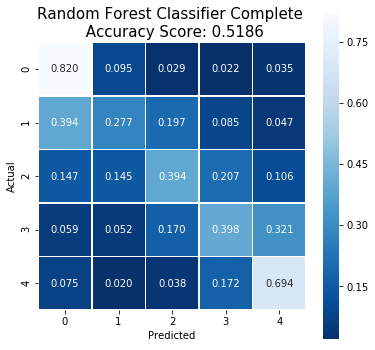

In [63]:
# evaluate and plot the confusion matrix
classifier_string_rfc_complete = 'Random Forest Classifier Complete'
classifier_result(confusion_matrix_rfc_complete, score_rfc_complete, classifier_string_rfc_complete)

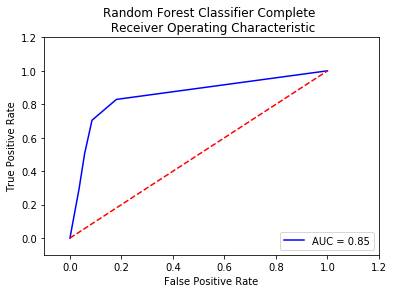

AUC of the predictions: 0.8533758857151684


In [64]:
# evaluate and plot the roc curve
fpr_rfc_complete, tpr_rfc_complete, thresholds_rfc_complete, roc_auc_rfc_complete = classifier_roc(prediction_rfc_complete, y_complete_test, classifier_string_rfc_complete)

### Neural Network Classifier

In [129]:
# Set classes, input shape, batch size, and epochs
num_classes = 6
max_words = X_complete_train.shape[1]
batch_size = 32
epochs = 2

In [66]:
# create classifier and define network layers
classifier_nn_complete = Sequential()
classifier_nn_complete.add(Dense(32, input_shape=(max_words,)))
classifier_nn_complete.add(Activation('relu'))
classifier_nn_complete.add(Dropout(0.5))
classifier_nn_complete.add(Dense(num_classes))
classifier_nn_complete.add(Activation('softmax'))

In [67]:
# compile neural network
classifier_nn_complete.compile(loss='sparse_categorical_crossentropy',
                               optimizer='adam',
                               metrics=['accuracy'])

In [68]:
# train and evaluate neural network
classifier_nn_complete, prediction_nn_complete, time_train_nn_complete, time_predict_nn_complete, score_nn_complete, accuracy_nn_complete, confusion_matrix_nn_complete = classifier_train_nn(classifier_nn_complete, X_complete_train, y_complete_train, X_complete_test, y_complete_test, batch_size, epochs)

Train on 16993 samples, validate on 1889 samples
Epoch 1/2
16993/16993 [==============================] - 185s 11ms/step - loss: 1.2798 - acc: 0.4810 - val_loss: 1.0326 - val_acc: 0.5770
Epoch 2/2
8093/8093 [==============================] - ETA:  - 27s 3ms/step


Score: 1.0129225383240288
Accuracy: 0.5782775238301777


Confusion Matrix: 
 [[1185  359   42   16   45]
 [ 335  889  283   91   55]
 [  85  371  637  390  105]
 [  27   78  251  741  465]
 [  28   35   59  293 1228]]


Training time: 369.167s; Prediction time: 25.687s
             precision    recall  f1-score   support

          1       0.71      0.72      0.72      1647
          2       0.51      0.54      0.53      1653
          3       0.50      0.40      0.45      1588
          4       0.48      0.47      0.48      1562
          5       0.65      0.75      0.69      1643

avg / total       0.57      0.58      0.57      8093



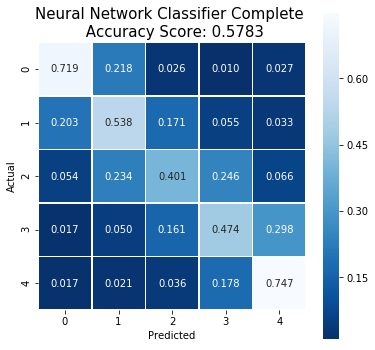

In [69]:
# evaluate and plot confusion matrix
classifier_string_nn_complete = 'Neural Network Classifier Complete'
classifier_result(confusion_matrix_nn_complete, accuracy_nn_complete, classifier_string_nn_complete)

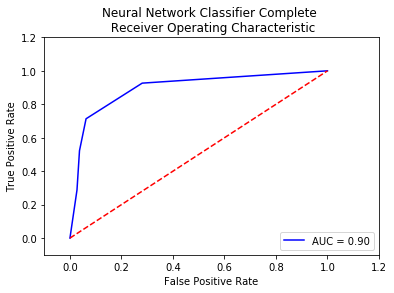

AUC of the predictions: 0.8952949646034187


In [70]:
# evaluate and plot the roc curve
fpr_nn_complete, tpr_nn_complete, thresholds_nn_complete, roc_auc_nn_complete = classifier_roc(prediction_nn_complete, y_complete_test, classifier_string_nn_complete)

# Boundary Conditions

### Multinomial Naive Bayes Classifier

In [71]:
# create and train multinomial naive bayes classifier
classifier_nb_boundary = multinomial_nb()
classifier_nb_boundary, prediction_nb_boundary, time_train_nb_boundary, time_predict_nb_boundary, score_nb_boundary, confusion_matrix_nb_boundary = classifier_train(classifier_nb_boundary, X_boundary_train, y_boundary_train, X_boundary_test, y_boundary_test)

Score: 0.9295644114921223


Confusion Matrix: 
 [[1517  102]
 [ 126 1492]]


Training time: 0.056s; Prediction time: 0.012s
             precision    recall  f1-score   support

          1       0.92      0.94      0.93      1619
          5       0.94      0.92      0.93      1618

avg / total       0.93      0.93      0.93      3237



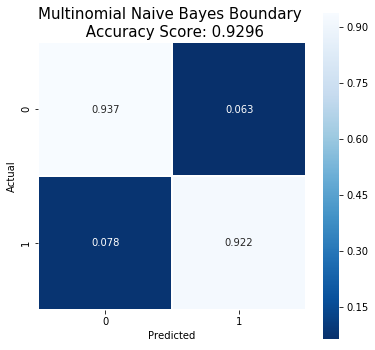

In [72]:
# evaluate and plot the confusion matrix
classifier_string_nb_boundary = 'Multinomial Naive Bayes Boundary'
classifier_result(confusion_matrix_nb_boundary, score_nb_boundary, classifier_string_nb_boundary)

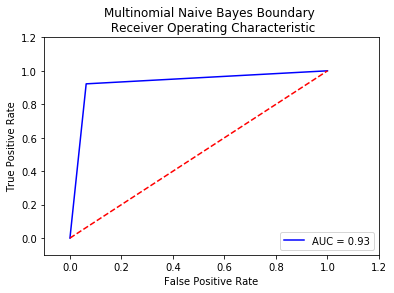

AUC of the predictions: 0.9295621142932619


In [73]:
# evaluate and plot the roc curve
fpr_nb_boundary, tpr_nb_boundary, thresholds_nb_boundary, roc_auc_nb_boundary = classifier_roc(prediction_nb_boundary, y_boundary_test, classifier_string_nb_boundary)

#### Extend to complete case

In [163]:
# evaluate multinomial naive bayes classifier
classifier_nb_boundary_extended, prediction_nb_boundary_extended, time_predict_nb_boundary_extended, score_nb_boundary_extended, confusion_matrix_nb_boundary_extended = classifier_evaluate(classifier_nb_boundary, X_complete_test, y_complete_test)

Score: 0.1902879031261584


Confusion Matrix: 
 [[ 127   87   65  131 1237]
 [ 100   84   65  134 1270]
 [ 112   58   61  114 1243]
 [ 125   74   81  124 1158]
 [ 142  102   85  170 1144]]


Prediction time: 0.046s
             precision    recall  f1-score   support

          1       0.21      0.08      0.11      1647
          2       0.21      0.05      0.08      1653
          3       0.17      0.04      0.06      1588
          4       0.18      0.08      0.11      1562
          5       0.19      0.70      0.30      1643

avg / total       0.19      0.19      0.13      8093



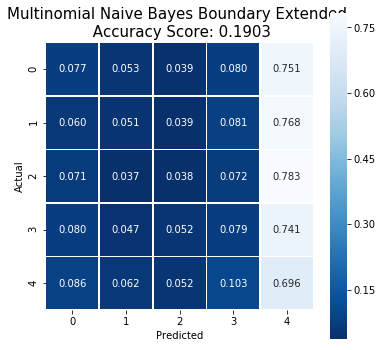

In [164]:
# evaluate and plot the confusion matrix
classifier_string_nb_boundary_extended = 'Multinomial Naive Bayes Boundary Extended'
classifier_result(confusion_matrix_nb_boundary_extended, score_nb_boundary_extended, classifier_string_nb_boundary_extended)

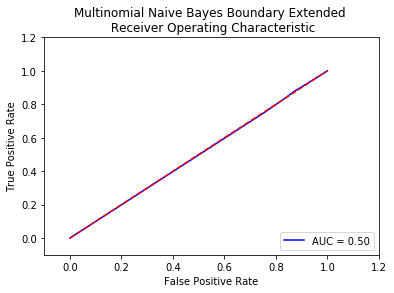

AUC of the predictions: 0.49880177782600427


In [165]:
# evaluate and plot the roc curve
fpr_nb_boundary_extended, tpr_nb_boundary_extended, thresholds_nb_boundary_extended, roc_auc_nb_boundary_extended = classifier_roc(prediction_nb_boundary_extended, y_complete_test, classifier_string_nb_boundary_extended)

### Linear SVM Classifier

In [77]:
# create and train linear svm classifier
classifier_ln_boundary = svm.SVC(kernel='linear', probability=True)
classifier_ln_boundary, prediction_ln_boundary, time_train_ln_boundary, time_predict_ln_boundary, score_ln_boundary, confusion_matrix_ln_boundary = classifier_train(classifier_ln_boundary, X_boundary_train, y_boundary_train, X_boundary_test, y_boundary_test)

Score: 0.946555452579549


Confusion Matrix: 
 [[1533   86]
 [  87 1531]]


Training time: 64.195s; Prediction time: 4.227s
             precision    recall  f1-score   support

          1       0.95      0.95      0.95      1619
          5       0.95      0.95      0.95      1618

avg / total       0.95      0.95      0.95      3237



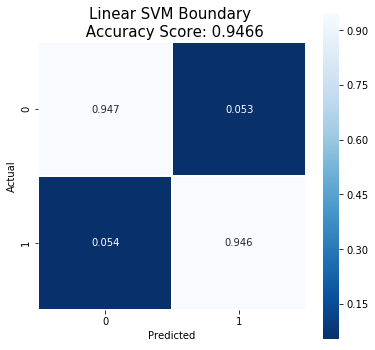

In [78]:
# evaluate and plot the confusion matrix
classifier_string_ln_boundary = 'Linear SVM Boundary'
classifier_result(confusion_matrix_ln_boundary, score_ln_boundary, classifier_string_ln_boundary)

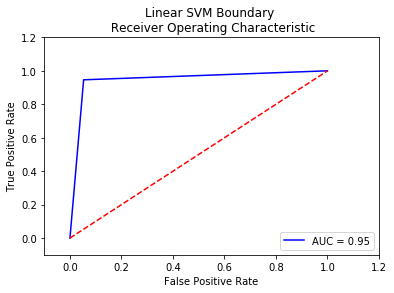

AUC of the predictions: 0.9465553520424563


In [79]:
# evaluate and plot the roc curve
fpr_ln_boundary, tpr_ln_boundary, thresholds_ln_boundary, roc_auc_ln_boundary = classifier_roc(prediction_ln_boundary, y_boundary_test, classifier_string_ln_boundary)

#### Extend to complete case

In [80]:
# evaluate linear svm classifier
classifier_ln_boundary_extended, prediction_ln_boundary_extended, time_predict_ln_boundary_extended, score_ln_boundary_extended, confusion_matrix_ln_boundary_extended = classifier_evaluate(classifier_ln_boundary, X_complete_test, y_complete_test)

Score: 0.19350055603608057


Confusion Matrix: 
 [[   4  258 1328   53    4]
 [   2  264 1338   47    2]
 [   2  285 1264   37    0]
 [   1  248 1280   33    0]
 [   3  239 1375   25    1]]


Prediction time: 18.039s
             precision    recall  f1-score   support

          1       0.33      0.00      0.00      1647
          2       0.20      0.16      0.18      1653
          3       0.19      0.80      0.31      1588
          4       0.17      0.02      0.04      1562
          5       0.14      0.00      0.00      1643

avg / total       0.21      0.19      0.11      8093



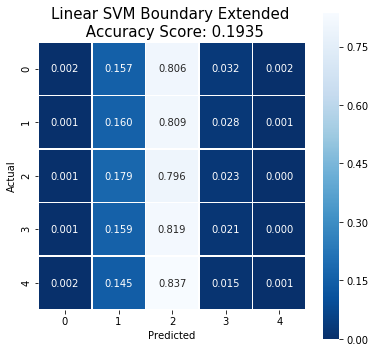

In [166]:
# evaluate and plot the confusion matrix
classifier_string_ln_boundary_extended = 'Linear SVM Boundary Extended'
classifier_result(confusion_matrix_ln_boundary_extended, score_ln_boundary_extended, classifier_string_ln_boundary_extended)

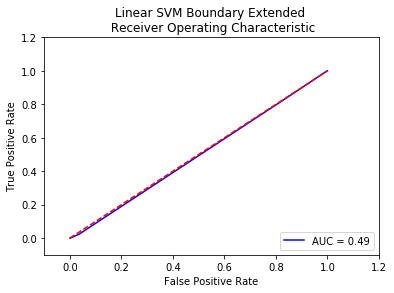

AUC of the predictions: 0.4935933120345362


In [167]:
# evaluate and plot the roc curve
fpr_ln_boundary_extended, tpr_ln_boundary_extended, thresholds_ln_boundary_extended, roc_auc_ln_boundary_extended = classifier_roc(prediction_ln_boundary_extended, y_complete_test, classifier_string_ln_boundary_extended)

### Linear SVC Classifier

In [83]:
# create and train linear svc classifier
classifier_lnlib_boundary = svm.LinearSVC()
classifier_lnlib_boundary = CalibratedClassifierCV(classifier_lnlib_boundary) 
classifier_lnlib_boundary, prediction_lnlib_boundary, time_train_lnlib_boundary, time_predict_lnlib_boundary, score_lnlib_boundary, confusion_matrix_lnlib_boundary = classifier_train(classifier_lnlib_boundary, X_boundary_train, y_boundary_train, X_boundary_test, y_boundary_test)

Score: 0.9453197405004634


Confusion Matrix: 
 [[1533   86]
 [  91 1527]]


Training time: 0.510s; Prediction time: 0.006s
             precision    recall  f1-score   support

          1       0.94      0.95      0.95      1619
          5       0.95      0.94      0.95      1618

avg / total       0.95      0.95      0.95      3237



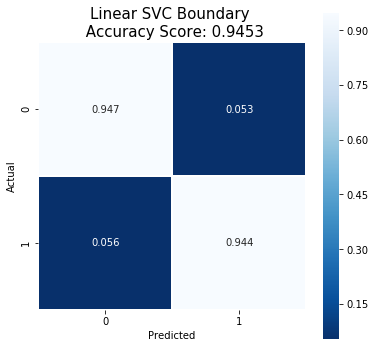

In [84]:
# evaluate and plot the confusion matrix
classifier_string_lnlib_boundary = 'Linear SVC Boundary'
classifier_result(confusion_matrix_lnlib_boundary, score_lnlib_boundary, classifier_string_lnlib_boundary)

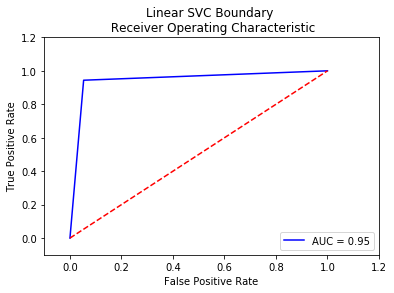

AUC of the predictions: 0.9453192580993167


In [85]:
# evaluate and plot the roc curve
fpr_lnlib_boundary, tpr_lnlib_boundary, thresholds_lnlib_boundary, roc_auc_lnlib_boundary = classifier_roc(prediction_lnlib_boundary, y_boundary_test, classifier_string_lnlib_boundary)

#### Extend to complete case

In [86]:
# evaluate linear svc classifier
classifier_lnlib_boundary_extended, prediction_lnlib_boundary_extended, time_predict_lnlib_boundary_extended, score_lnlib_boundary_extended, confusion_matrix_lnlib_boundary_extended = classifier_evaluate(classifier_lnlib_boundary, X_complete_test, y_complete_test)

Score: 0.19572470035833436


Confusion Matrix: 
 [[   2  164 1454   26    1]
 [   1  162 1467   22    1]
 [   1  163 1407   17    0]
 [   0  147 1403   12    0]
 [   0  122 1511    9    1]]


Prediction time: 0.044s
             precision    recall  f1-score   support

          1       0.50      0.00      0.00      1647
          2       0.21      0.10      0.13      1653
          3       0.19      0.89      0.32      1588
          4       0.14      0.01      0.01      1562
          5       0.33      0.00      0.00      1643

avg / total       0.28      0.20      0.09      8093



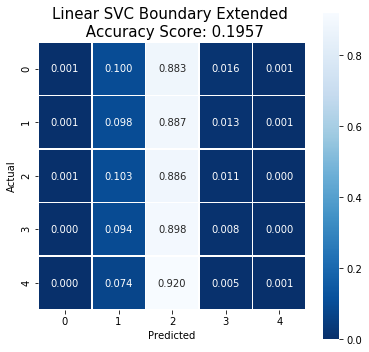

In [168]:
# evaluate and plot the confusion matrix
classifier_string_lnlib_boundary_extended = 'Linear SVC Boundary Extended'
classifier_result(confusion_matrix_lnlib_boundary_extended, score_lnlib_boundary_extended, classifier_string_lnlib_boundary_extended)

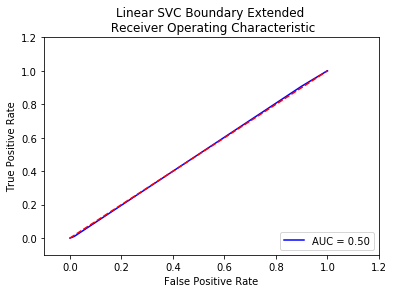

AUC of the predictions: 0.5010901834322636


In [169]:
# evaluate and plot the roc curve
fpr_lnlib_boundary_extended, tpr_lnlib_boundary_extended, thresholds_lnlib_boundary_extended, roc_auc_lnlib_boundary_extended = classifier_roc(prediction_lnlib_boundary_extended, y_complete_test, classifier_string_lnlib_boundary_extended)

### Logistic Regression Classifier

In [89]:
# create and train linear svc classifier
classifier_lr_boundary = LogisticRegression()
classifier_lr_boundary, prediction_lr_boundary, time_train_lr_boundary, time_predict_lr_boundary, score_lr_boundary, confusion_matrix_lr_boundary = classifier_train(classifier_lr_boundary, X_boundary_train, y_boundary_train, X_boundary_test, y_boundary_test)

Score: 0.9490268767377201


Confusion Matrix: 
 [[1537   82]
 [  83 1535]]


Training time: 1.284s; Prediction time: 0.003s
             precision    recall  f1-score   support

          1       0.95      0.95      0.95      1619
          5       0.95      0.95      0.95      1618

avg / total       0.95      0.95      0.95      3237



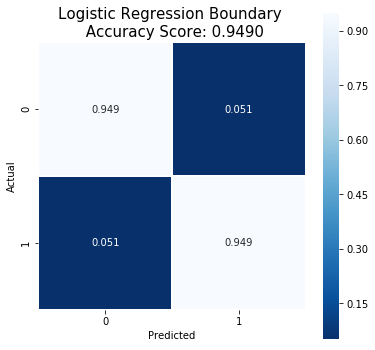

In [90]:
# evaluate and plot the confusion matrix
classifier_string_lr_boundary = 'Logistic Regression Boundary'
classifier_result(confusion_matrix_lr_boundary, score_lr_boundary, classifier_string_lr_boundary)

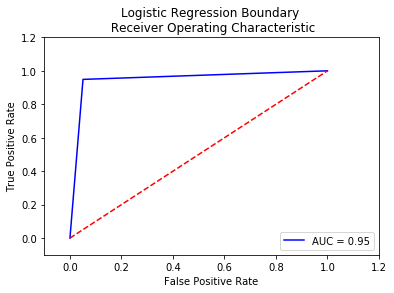

AUC of the predictions: 0.9490267764364916


In [91]:
# evaluate and plot the roc curve
fpr_lr_boundary, tpr_lr_boundary, thresholds_lr_boundary, roc_auc_lr_boundary = classifier_roc(prediction_lr_boundary, y_boundary_test, classifier_string_lr_boundary)

#### Extend to complete case

In [92]:
# evaluate linear svc classifier
classifier_lr_boundary_extended, prediction_lr_boundary_extended, time_predict_lr_boundary_extended, score_lr_boundary_extended, confusion_matrix_lr_boundary_extended = classifier_evaluate(classifier_lr_boundary, X_complete_test, y_complete_test)

Score: 0.19461262819720745


Confusion Matrix: 
 [[   3  163 1432   45    4]
 [   1  170 1448   30    4]
 [   2  180 1379   27    0]
 [   1  151 1386   22    2]
 [   1  126 1498   17    1]]


Prediction time: 0.027s
             precision    recall  f1-score   support

          1       0.38      0.00      0.00      1647
          2       0.22      0.10      0.14      1653
          3       0.19      0.87      0.32      1588
          4       0.16      0.01      0.03      1562
          5       0.09      0.00      0.00      1643

avg / total       0.21      0.19      0.10      8093



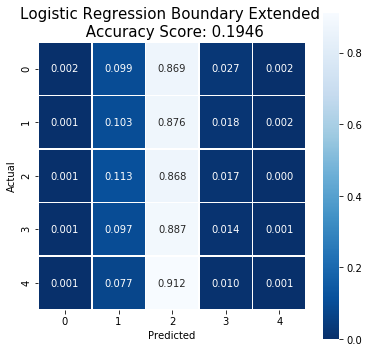

In [170]:
# evaluate and plot the confusion matrix
classifier_string_lr_boundary_extended = 'Logistic Regression Boundary Extended'
classifier_result(confusion_matrix_lr_boundary_extended, score_lr_boundary_extended, classifier_string_lr_boundary_extended)

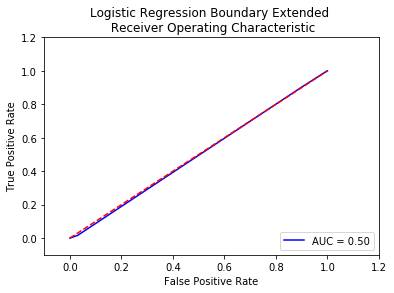

AUC of the predictions: 0.49518610638735966


In [171]:
# evaluate and plot the roc curve
fpr_lr_boundary_extended, tpr_lr_boundary_extended, thresholds_lr_boundary_extended, roc_auc_lr_boundary_extended = classifier_roc(prediction_lr_boundary_extended, y_complete_test, classifier_string_lr_boundary_extended)

### Random Forest Classifier

In [95]:
# create and train random forest classifier with 100 estimators and bootstaping enabled
classifier_rfc_boundary = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)
classifier_rfc_boundary, prediction_rfc_boundary, time_train_rfc_boundary, time_predict_rfc_boundary, score_rfc_boundary, confusion_matrix_rfc_boundary = classifier_train(classifier_rfc_boundary, X_boundary_train, y_boundary_train, X_boundary_test, y_boundary_test)
print('\n')
print('Out-of-bag score estimate: {0:.3f}'.format(classifier_rfc_boundary.oob_score_))

Score: 0.9218412109978376


Confusion Matrix: 
 [[1523   96]
 [ 157 1461]]


Training time: 146.052s; Prediction time: 0.848s
             precision    recall  f1-score   support

          1       0.91      0.94      0.92      1619
          5       0.94      0.90      0.92      1618

avg / total       0.92      0.92      0.92      3237



Out-of-bag score estimate: 0.899


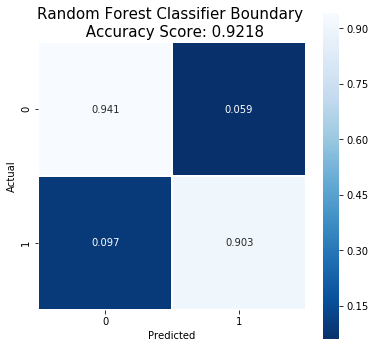

In [96]:
# evaluate and plot the confusion matrix
classifier_string_rfc_boundary = 'Random Forest Classifier Boundary'
classifier_result(confusion_matrix_rfc_boundary, score_rfc_boundary, classifier_string_rfc_boundary)

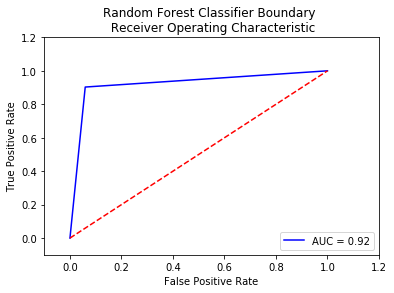

AUC of the predictions: 0.9218353819102729


In [97]:
# evaluate and plot the roc curve
fpr_rfc_boundary, tpr_rfc_boundary, thresholds_rfc_boundary, roc_auc_rfc_boundary = classifier_roc(prediction_rfc_boundary, y_boundary_test, classifier_string_rfc_boundary)

#### Extend to complete case

In [172]:
# evaluate random forest classifier with 100 estimators and bootstaping enabled
classifier_rfc_boundary_extended, prediction_rfc_boundary_extended, time_predict_rfc_boundary_extended, score_rfc_boundary_extended, confusion_matrix_rfc_boundary_extended = classifier_evaluate(classifier_rfc_boundary, X_complete_test, y_complete_test)

Score: 0.19510688249104163


Confusion Matrix: 
 [[   0   30 1606   11    0]
 [   0   24 1619   10    0]
 [   0   24 1549   15    0]
 [   0   16 1540    6    0]
 [   0   22 1617    4    0]]


Prediction time: 5.086s
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1647
          2       0.21      0.01      0.03      1653
          3       0.20      0.98      0.33      1588
          4       0.13      0.00      0.01      1562
          5       0.00      0.00      0.00      1643

avg / total       0.11      0.20      0.07      8093



/Users/seanpavlak/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


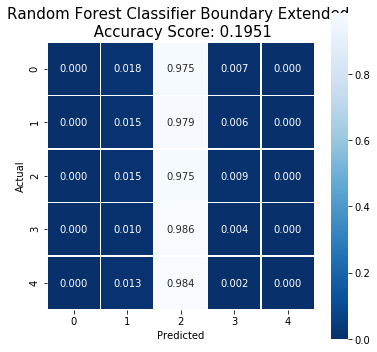

In [173]:
# evaluate and plot the confusion matrix
classifier_string_rfc_boundary_extended = 'Random Forest Classifier Boundary Extended'
classifier_result(confusion_matrix_rfc_boundary_extended, score_rfc_boundary_extended, classifier_string_rfc_boundary_extended)

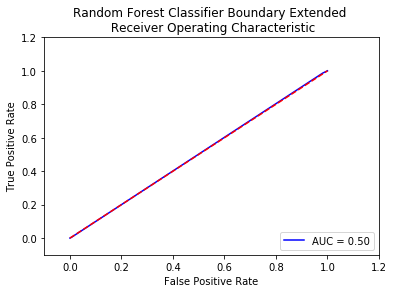

AUC of the predictions: 0.5018072234683884


In [174]:
# evaluate and plot the roc curve
fpr_rfc_boundary_extended, tpr_rfc_boundary_extended, thresholds_rfc_boundary_extended, roc_auc_rfc_boundary_extended = classifier_roc(prediction_rfc_boundary_extended, y_complete_test, classifier_string_rfc_boundary_extended)

### Neural Network Classifier

In [101]:
# Set classes, input shape, batch size, and epochs
num_classes = 6
max_words = X_boundary_train.shape[1]
batch_size = 32
epochs = 2

In [102]:
# create classifier and define network layers
classifier_nn_boundary = Sequential()
classifier_nn_boundary.add(Dense(32, input_shape=(max_words,)))
classifier_nn_boundary.add(Activation('relu'))
classifier_nn_boundary.add(Dropout(0.5))
classifier_nn_boundary.add(Dense(num_classes))
classifier_nn_boundary.add(Activation('softmax'))

In [103]:
# compile neural network
classifier_nn_boundary.compile(loss='sparse_categorical_crossentropy',
                               optimizer='adam',
                               metrics=['accuracy'])

In [104]:
# train and evaluate neural network
classifier_nn_boundary, prediction_nn_boundary, time_train_nn_boundary, time_predict_nn_boundary, score_nn_boundary, accuracy_nn_boundary, confusion_matrix_nn_boundary = classifier_train_nn(classifier_nn_boundary, X_boundary_train, y_boundary_train, X_boundary_test, y_boundary_test, batch_size, epochs)

Train on 6797 samples, validate on 756 samples
Epoch 1/2
6797/6797 [==============================] - 71s 10ms/step - loss: 0.6153 - acc: 0.8711 - val_loss: 0.1916 - val_acc: 0.9471
Epoch 2/2
3237/3237 [==============================] - 9s 3ms/step


Score: 0.14003351996780813
Accuracy: 0.9567500772320049


Confusion Matrix: 
 [[1526   93]
 [  47 1571]]


Training time: 137.672s; Prediction time: 9.054s
             precision    recall  f1-score   support

          1       0.97      0.94      0.96      1619
          5       0.94      0.97      0.96      1618

avg / total       0.96      0.96      0.96      3237



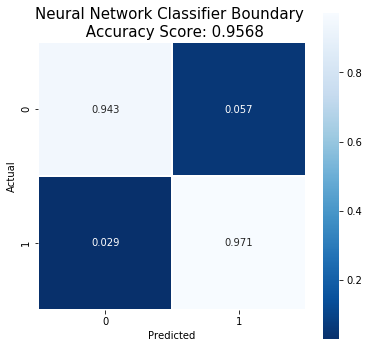

In [105]:
# evaluate and plot confusion matrix
classifier_string_nn_boundary = 'Neural Network Classifier Boundary'
classifier_result(confusion_matrix_nn_boundary, accuracy_nn_boundary, classifier_string_nn_boundary)

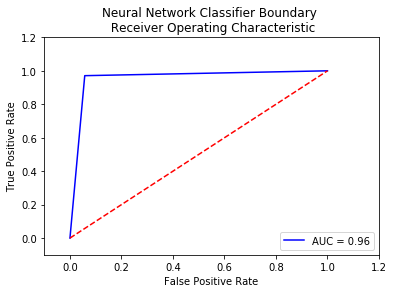

AUC of the predictions: 0.9567544631847857


In [109]:
# evaluate and plot the roc curve
fpr_nn_boundary, tpr_nn_boundary, thresholds_nn_boundary, roc_auc_nn_boundary = classifier_roc(prediction_nn_boundary, y_boundary_test, classifier_string_nn_boundary)

#### Extend to complete case

In [175]:
# evaluate neural network classifier
classifier_nn_boundary_extended, prediction_nn_boundary_extended, time_predict_nn_boundary_extended, score_nn_boundary_extended, confusion_matrix_nn_boundary_extended = classifier_evaluate_nn(classifier_nn_boundary, X_complete_test, y_complete_test)

8093/8093 [==============================] - 26s 3ms/step
Score: 0.19350055603608057


Confusion Matrix: 
 [[   0    0 1032  600   15]
 [   0    0 1051  588   14]
 [   0    0 1037  539   12]
 [   0    0 1016  540    6]
 [   0    0 1124  514    5]]


Prediction time: 48.845s
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1647
          2       0.00      0.00      0.00      1653
          3       0.20      0.65      0.30      1588
          4       0.19      0.35      0.25      1562
          5       0.10      0.00      0.01      1643

avg / total       0.10      0.20      0.11      8093



/Users/seanpavlak/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


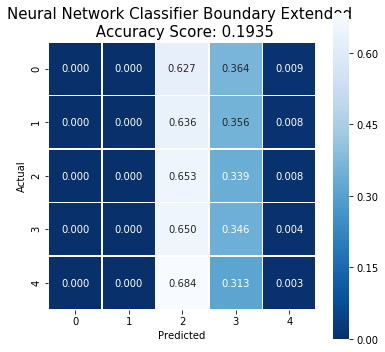

In [176]:
# evaluate and plot the confusion matrix
classifier_string_nn_boundary_extended = 'Neural Network Classifier Boundary Extended'
classifier_result(confusion_matrix_nn_boundary_extended, score_nn_boundary_extended, classifier_string_nn_boundary_extended)

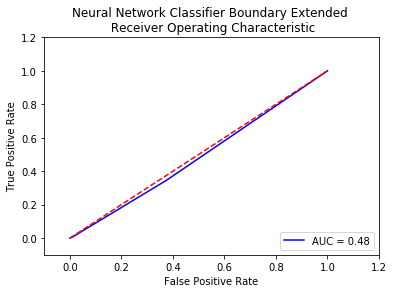

AUC of the predictions: 0.4848463655183289


In [177]:
# evaluate and plot the roc curve
fpr_nn_boundary_extended, tpr_nn_boundary_extended, thresholds_nn_boundary_extended, roc_auc_nn_boundary_extended = classifier_roc(prediction_nn_boundary_extended, y_complete_test, classifier_string_nn_boundary_extended)

## Results

### Complete Case

In [110]:
fprs = [fpr_ln_complete, fpr_lnlib_complete, fpr_lr_complete, fpr_nb_complete, fpr_nn_complete, fpr_rfc_complete]
tprs = [tpr_ln_complete, tpr_lnlib_complete, tpr_lr_complete, tpr_nb_complete, tpr_nn_complete, tpr_rfc_complete]
roc_aucs = [roc_auc_ln_complete, roc_auc_lnlib_complete, roc_auc_lr_complete, roc_auc_nb_complete, roc_auc_nn_complete, roc_auc_rfc_complete]

In [111]:
time_trains = [time_train_ln_complete, time_train_lnlib_complete, time_train_lr_complete, time_train_nb_complete, time_train_nn_complete, time_train_rfc_complete]
time_predict = [time_predict_ln_complete, time_predict_lnlib_complete, time_predict_lr_complete, time_predict_nb_complete, time_predict_nn_complete, time_predict_rfc_complete]

In [112]:
classifier_strings = [classifier_string_ln_complete, classifier_string_lnlib_complete, classifier_string_lr_complete, classifier_string_nb_complete, classifier_string_nn_complete, classifier_string_rfc_complete]

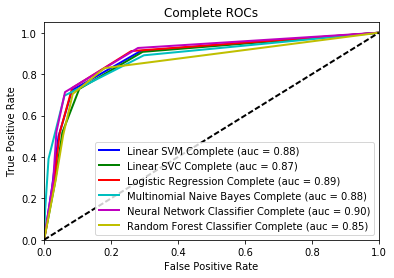

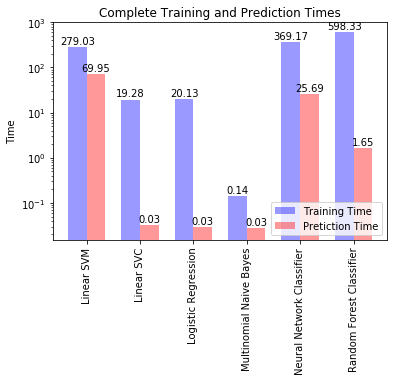

In [113]:
classifiers_plots(fprs, tprs, roc_aucs, time_trains, time_predict, classifier_strings, 'Complete')

### Boundary Case

In [114]:
fprs = [fpr_ln_boundary, fpr_lnlib_boundary, fpr_lr_boundary, fpr_nb_boundary, fpr_nn_boundary, fpr_rfc_boundary]
tprs = [tpr_ln_boundary, tpr_lnlib_boundary, tpr_lr_boundary, tpr_nb_boundary, tpr_nn_boundary, tpr_rfc_boundary]
roc_aucs = [roc_auc_ln_boundary, roc_auc_lnlib_boundary, roc_auc_lr_boundary, roc_auc_nb_boundary, roc_auc_nn_boundary, roc_auc_rfc_boundary]

In [115]:
time_trains = [time_train_ln_boundary, time_train_lnlib_boundary, time_train_lr_boundary, time_train_nb_boundary, time_train_nn_boundary, time_train_rfc_boundary]
time_predict = [time_predict_ln_boundary, time_predict_lnlib_boundary, time_predict_lr_boundary, time_predict_nb_boundary, time_predict_nn_boundary, time_predict_rfc_boundary]

In [116]:
classifier_strings = [classifier_string_ln_boundary, classifier_string_lnlib_boundary, classifier_string_lr_boundary, classifier_string_nb_boundary, classifier_string_nn_boundary, classifier_string_rfc_boundary]

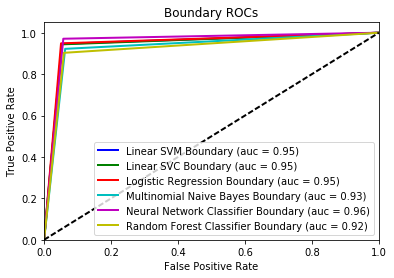

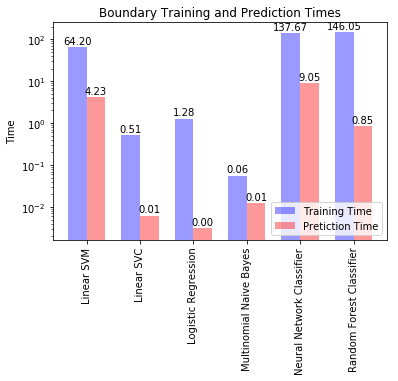

In [117]:
classifiers_plots(fprs, tprs, roc_aucs, time_trains, time_predict, classifier_strings, 'Boundary')

### Extended Boundary Case

In [118]:
fprs = [fpr_ln_boundary_extended, fpr_lnlib_boundary_extended, fpr_lr_boundary_extended, fpr_nb_boundary_extended, fpr_nn_boundary_extended, fpr_rfc_boundary_extended]
tprs = [tpr_ln_boundary_extended, tpr_lnlib_boundary_extended, tpr_lr_boundary_extended, tpr_nb_boundary_extended, tpr_nn_boundary_extended, tpr_rfc_boundary_extended]
roc_aucs = [roc_auc_ln_boundary_extended, roc_auc_lnlib_boundary_extended, roc_auc_lr_boundary_extended, roc_auc_nb_boundary_extended, roc_auc_nn_boundary_extended, roc_auc_rfc_boundary_extended]

In [119]:
time_trains = [time_train_ln_boundary, time_train_lnlib_boundary, time_train_lr_boundary, time_train_nb_boundary, time_train_nn_boundary, time_train_rfc_boundary]
time_predict = [time_predict_ln_boundary_extended, time_predict_lnlib_boundary_extended, time_predict_lr_boundary_extended, time_predict_nb_boundary_extended, time_predict_nn_boundary_extended, time_predict_rfc_boundary_extended]

In [120]:
classifier_strings = [classifier_string_ln_boundary_extended, classifier_string_lnlib_boundary_extended, classifier_string_lr_boundary_extended, classifier_string_nb_boundary_extended, classifier_string_nn_boundary_extended, classifier_string_rfc_boundary_extended]

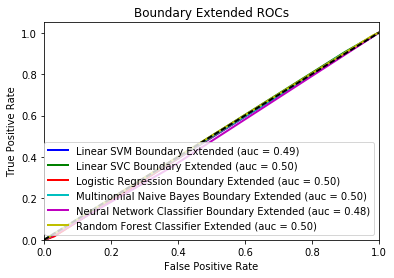

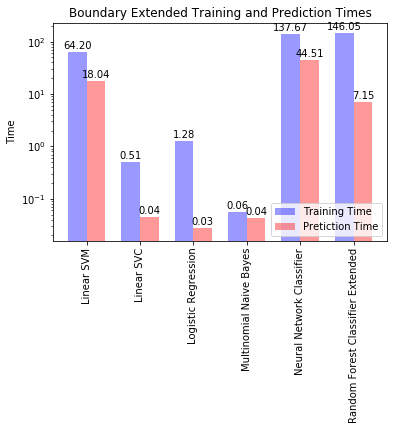

In [121]:
classifiers_plots(fprs, tprs, roc_aucs, time_trains, time_predict, classifier_strings, 'Boundary Extended')